In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
from scipy.signal import butter, lfilter
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from tqdm import tqdm
from torch import optim

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Onde -> Spectogramme

In [2]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def overlap(X, window_size, window_step):
    """
    Create an overlapped version of X
    Parameters
    ----------
    X : ndarray, shape=(n_samples,)
        Input signal to window and overlap
    window_size : int
        Size of windows to take
    window_step : int
        Step size between windows
    Returns
    -------
    X_strided : shape=(n_windows, window_size)
        2D array of overlapped X
    """
    window_size, window_step = map(int, (window_size, window_step))
    if window_size % 2 != 0:
        raise ValueError("Window size must be even!")
    # Make sure there are an even number of windows before stridetricks
    append = np.zeros((window_size - len(X) % window_size))
    X = np.hstack((X, append))

    ws = window_size
    ss = window_step
    a = X

    valid = len(a) - ws
    nw = (valid) // ss
    out = np.ndarray((nw, ws), dtype=a.dtype)

    for i in range(nw):
        # "slide" the window along the samples
        start = i * ss
        stop = start + ws
        out[i] = a[start: stop]

    return out


def normalisation(X):
    minX = np.min(X)
    maxX = np.max(X)

    return (X - minX)/(maxX - minX)


def stft(X, fftsize=128, step=65, mean_normalize=True, real=False,
         compute_onesided=True):
    """
    Compute STFT for 1D real valued input X
    """
    if real:
        local_fft = np.fft.rfft
        cut = -1
    else:
        local_fft = np.fft.fft
        cut = None
    if compute_onesided:
        cut = fftsize // 2
    if mean_normalize:
        X -= X.mean()

    X = overlap(X, fftsize, step)

    size = fftsize
    win = 0.54 - .46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))
    X = X * win[None]
    X = local_fft(X)[:, :cut]
    return X


def pretty_spectrogram(d, log=True, thresh=5, fft_size=512, step_size=64):
    """
    creates a spectrogram
    log: take the log of the spectrgram
    thresh: threshold minimum power for log spectrogram
    """
    specgram = np.abs(stft(d, fftsize=fft_size, step=step_size, real=False,
                           compute_onesided=True))

    if log == True:
        specgram /= specgram.max()  # volume normalize to max 1
        specgram = np.log10(specgram)  # take log
        specgram[specgram < -thresh] = -thresh  # set anything less than the threshold as the threshold
    else:
        specgram[specgram < thresh] = thresh  # set anything less than the threshold as the threshold

    return normalisation(specgram)

# Spectogramme -> Onde

In [61]:
# Also mostly modified or taken from https://gist.github.com/kastnerkyle/179d6e9a88202ab0a2fe
def invert_pretty_spectrogram(X_s, log=True, fft_size=512, step_size=512 / 4, n_iter=10):
    if log == True:
        X_s = np.power(10, X_s)

    X_s = np.concatenate([X_s, X_s[:, ::-1]], axis=1)
    X_t = iterate_invert_spectrogram(X_s, fft_size, step_size, n_iter=n_iter)
    return X_t


def iterate_invert_spectrogram(X_s, fftsize, step, n_iter=10, verbose=False):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    reg = np.max(X_s) / 1e8
    X_best = copy.deepcopy(X_s)
    for i in range(n_iter):
        if verbose:
            print("Runnning iter %i" % i)
        if i == 0:
            X_t = invert_spectrogram(
                X_best, step, calculate_offset=True, set_zero_phase=True
            )
        else:
            # Calculate offset was False in the MATLAB version
            # but in mine it massively improves the result
            # Possible bug in my impl?
            X_t = invert_spectrogram(
                X_best, step, calculate_offset=True, set_zero_phase=False
            )
        est = stft(X_t, fftsize=fftsize, step=step, compute_onesided=False)
        phase = est / np.maximum(reg, np.abs(est))
        X_best = X_s * phase[: len(X_s)]
    X_t = invert_spectrogram(X_best, step, calculate_offset=True, set_zero_phase=False)
    return np.real(X_t)


def invert_spectrogram(X_s, step, calculate_offset=True, set_zero_phase=True):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    size = int(X_s.shape[1] // 2)
    wave = np.zeros(int(X_s.shape[0] * step + size))
    # Getting overflow warnings with 32 bit...
    wave = wave.astype("float64")
    total_windowing_sum = np.zeros(int(X_s.shape[0] * step + size))
    win = 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))

    est_start = int(size // 2) - 1
    est_end = est_start + size
    for i in range(X_s.shape[0]):
        wave_start = int(step * i)
        wave_end = wave_start + size
        if set_zero_phase:
            spectral_slice = X_s[i].real + 0j
        else:
            # already complex
            spectral_slice = X_s[i]

        # Don't need fftshift due to different impl.
        wave_est = np.real(np.fft.ifft(spectral_slice))[::-1]
        if calculate_offset and i > 0:
            offset_size = size - step
            if offset_size <= 0:
                print(
                    "WARNING: Large step size >50\% detected! "
                    "This code works best with high overlap - try "
                    "with 75% or greater"
                )
                offset_size = step
            offset = xcorr_offset(
                wave[wave_start: int(wave_start + offset_size)],
                wave_est[est_start: int(est_start + offset_size)],
            )
        else:
            offset = 0
        wave[wave_start:wave_end] += (
                win * wave_est[int(est_start - offset): int(est_end - offset)]
        )
        total_windowing_sum[wave_start:wave_end] += win
    wave = np.real(wave) / (total_windowing_sum + 1e-6)
    return wave

def xcorr_offset(x1, x2):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    x1 = x1 - x1.mean()
    x2 = x2 - x2.mean()
    frame_size = len(x2)
    half = frame_size // 2
    corrs = np.convolve(x1.astype("float32"), x2[::-1].astype("float32"))
    corrs[:half] = -1e30
    corrs[-half:] = -1e30
    offset = corrs.argmax() - len(x1)
    return offset

# Création de la classe Dataset

In [179]:
### Parameters ###
fft_size = 512 # window size for the FFT
step_size = fft_size/16 # distance to slide along the window (in time)
spec_thresh = 10 # threshold for spectrograms (lower filters out more noise)

class CustomDataset(Dataset):
    def __init__(self, clean_data, noisy_data):
        self.clean = clean_data
        self.noisy = noisy_data

    def __len__(self):
        return len(self.clean)

    def __getitem__(self, index):
        clean_spec = signal.stft(self.clean[index, :], nperseg=254, noverlap=120)[2].reshape((1, 128, 32))
        noisy_spec = signal.stft(self.noisy[index, :], nperseg=254, noverlap=120)[2].reshape((1, 128, 32))

        clean_tensor = torch.from_numpy(clean_spec).to(torch.float32)
        noisy_tensor = torch.from_numpy(noisy_spec).to(torch.float32)
        return clean_tensor, noisy_tensor

# Configuration des paramètres du CNN

In [180]:
class config:
    batch_size=1
    learning_rate=1e-3
    epochs=20

# Création du dataset

In [181]:
clean = pd.read_csv('label.csv').to_numpy()
noisy = pd.read_csv('train.csv').to_numpy()

test_clean = clean[:10]
test_noisy = noisy[:10]

training_dataset = CustomDataset(clean[10:900], noisy[10:900])
validation_dataset = CustomDataset(clean[900:], noisy[900:])

trainloader = DataLoader(training_dataset, batch_size=config.batch_size)
validloader = DataLoader(validation_dataset, batch_size=config.batch_size)

# Affichage d'un spectrogramme

(128, 32)


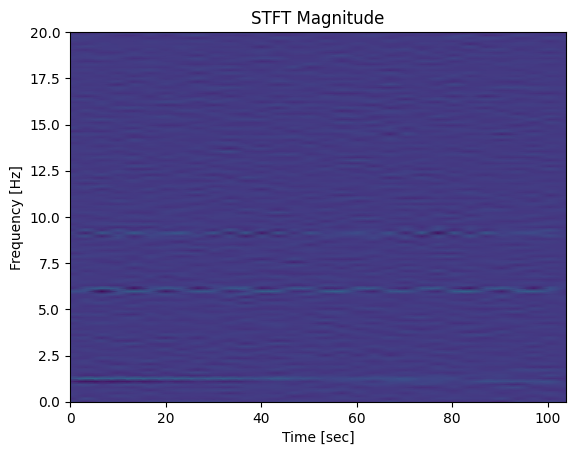

(800.0, 900.0)

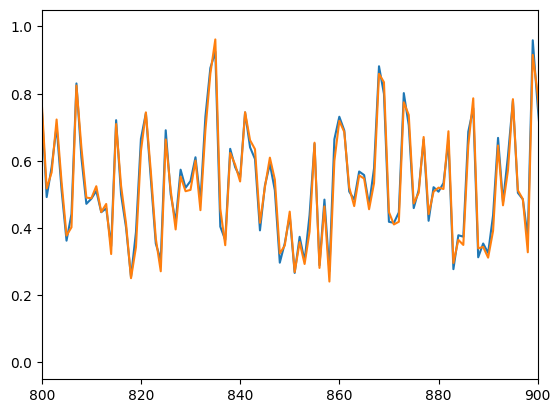

In [182]:
### Parameters ###
fft_size = 512 # window size for the FFT
step_size = fft_size/16 # distance to slide along the window (in time)
spec_thresh = 10 # threshold for spectrograms (lower filters out more noise)

s = test_noisy[6, :]

X = pretty_spectrogram(s.astype('float64'), fft_size=fft_size, step_size=step_size, log=False)

# X = normalisation(X)

# fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
# cax = ax.matshow(np.transpose(X), interpolation='bilinear', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
# fig.colorbar(cax)
# plt.title('Original Spectrogram')

X = invert_pretty_spectrogram(X, fft_size=fft_size, step_size=step_size, log=False)


from scipy import signal

f, t, Zxx = signal.stft(s, 40, nperseg=254, noverlap=120)
amp = 2 * np.sqrt(2)

Zxx = normalisation(Zxx)

print(Zxx.shape)

t2, x = signal.istft(Zxx, 40, nperseg=254, noverlap=120)

plt.figure()
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=amp, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()


plt.figure()
plt.plot(np.arange(0, 4096, 1), normalisation(x[:4096]))
plt.plot(np.arange(0, 4096, 1), normalisation(s))
plt.xlim([800, 900])


# Création du modèle

In [189]:
class autoencoders(nn.Module):
    def __init__(self):
        super(autoencoders, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = 5, padding = "same"),
            nn.ReLU(),
            nn.MaxPool2d((2,2), padding = 0),
            nn.Conv2d(32, 64, kernel_size = 5, padding = "same"),
            nn.ReLU(),
            nn.MaxPool2d((2,2), padding = 0),
            nn.Conv2d(64, 128, kernel_size = 5, padding = "same"),
            nn.ReLU(),
            nn.MaxPool2d((2,2), padding = 0)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size = 5, stride = 2, output_padding=1, padding = 2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size = 5, stride = 2, output_padding=1, padding = 2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size = 5, stride = 2, output_padding=1, padding = 2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size = 5, stride = 1, padding = 2),
            nn.Sigmoid()
        )

    def forward(self, images):
        x = self.encoder(images)
        x = self.decoder(x)
        return x

# Résumé du Modèle

In [190]:
model = autoencoders().to(device)

summary(model, (1, 128, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 128, 32]             832
              ReLU-2          [-1, 32, 128, 32]               0
         MaxPool2d-3           [-1, 32, 64, 16]               0
            Conv2d-4           [-1, 64, 64, 16]          51,264
              ReLU-5           [-1, 64, 64, 16]               0
         MaxPool2d-6            [-1, 64, 32, 8]               0
            Conv2d-7           [-1, 128, 32, 8]         204,928
              ReLU-8           [-1, 128, 32, 8]               0
         MaxPool2d-9           [-1, 128, 16, 4]               0
  ConvTranspose2d-10           [-1, 128, 32, 8]         409,728
             ReLU-11           [-1, 128, 32, 8]               0
  ConvTranspose2d-12           [-1, 64, 64, 16]         204,864
             ReLU-13           [-1, 64, 64, 16]               0
  ConvTranspose2d-14          [-1, 32, 

# Fonctions d'entrainement et de validation

In [215]:
def trainA(dataloader, model, epoch, loss_fn, optimizer, device):
    model.train()
    total_loss = 0.0
    for i, (clean, noisy) in enumerate(tqdm(dataloader)):

        clean = clean.to(device)
        noisy = noisy.to(device)

        optimizer.zero_grad()
        pred = model(noisy)

        _, pred1D = signal.istft(pred.cpu().detach().numpy().reshape(128, 32), 40, nperseg=254, noverlap=120)
        _, clean1D = signal.istft(clean.cpu().detach().numpy().reshape(128, 32), 40, nperseg=254, noverlap=120)

        pred1D = torch.from_numpy(pred1D[:4096].reshape(1, 4096)).to(torch.float32).to(device)
        clean1D = torch.from_numpy(clean1D[:4096].reshape(1, 4096)).to(torch.float32).to(device)

        curr_loss = loss_fn(pred1D, clean1D)

        curr_loss.requires_grad = True

        curr_loss.backward()
        optimizer.step()

        total_loss += curr_loss
        if i % 1000 == 0:
            print('[Epoch number : %d, Mini-batches: %5d] loss: %.3f' %
                  (epoch + 1, i + 1, total_loss / 200))
            total_loss = 0.0

def valA(dataloader, model, epoch, loss_fn, device):
    model.eval()
    total_loss = 0.0
    print('-------------------------')
    with torch.no_grad():
        for i, (clean, noisy) in enumerate(tqdm(dataloader)):
            clean = clean.to(device)
            noisy = noisy.to(device)

            output = model(noisy)
            loss = loss_fn(output, clean)
            total_loss += loss
            if i % 100 == 0:
                print('[Valid Epoch number : %d, Mini-batches: %5d] loss: %.3f' %
                      (epoch + 1, i + 1, total_loss / 200))
                total_loss = 0.0

# Entrainement du CNN

In [216]:
model = autoencoders().to(device)

optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
loss_fn = torch.nn.functional.mse_loss

for epoch in range(config.epochs):
    trainA(trainloader, model, epoch, loss_fn, optimizer, device)
    valA(validloader, model, epoch, loss_fn, device)

  2%|▏         | 14/890 [00:00<00:06, 135.19it/s]

[Epoch number : 1, Mini-batches:     1] loss: 0.007


100%|██████████| 890/890 [00:02<00:00, 301.23it/s]


-------------------------


 48%|████▊     | 48/99 [00:00<00:00, 479.83it/s]

[Valid Epoch number : 1, Mini-batches:     1] loss: 0.001


  3%|▎         | 30/890 [00:00<00:02, 298.89it/s]

[Epoch number : 2, Mini-batches:     1] loss: 0.007


100%|██████████| 890/890 [00:02<00:00, 302.86it/s]


-------------------------


 97%|█████████▋| 96/99 [00:00<00:00, 476.29it/s]

[Valid Epoch number : 2, Mini-batches:     1] loss: 0.001


  4%|▍         | 34/890 [00:00<00:02, 339.25it/s]

[Epoch number : 3, Mini-batches:     1] loss: 0.007


100%|██████████| 890/890 [00:02<00:00, 312.80it/s]


-------------------------


 54%|█████▎    | 53/99 [00:00<00:00, 522.09it/s]

[Valid Epoch number : 3, Mini-batches:     1] loss: 0.001


  8%|▊         | 72/890 [00:00<00:02, 354.88it/s]

[Epoch number : 4, Mini-batches:     1] loss: 0.007


100%|██████████| 890/890 [00:02<00:00, 353.52it/s]


-------------------------


100%|██████████| 99/99 [00:00<00:00, 507.28it/s]

[Valid Epoch number : 4, Mini-batches:     1] loss: 0.001



  7%|▋         | 58/890 [00:00<00:02, 294.08it/s]

[Epoch number : 5, Mini-batches:     1] loss: 0.007


100%|██████████| 890/890 [00:02<00:00, 309.81it/s]


-------------------------


 52%|█████▏    | 51/99 [00:00<00:00, 504.62it/s]

[Valid Epoch number : 5, Mini-batches:     1] loss: 0.001


  3%|▎         | 30/890 [00:00<00:02, 291.59it/s]

[Epoch number : 6, Mini-batches:     1] loss: 0.007


100%|██████████| 890/890 [00:02<00:00, 317.76it/s]


-------------------------


 52%|█████▏    | 51/99 [00:00<00:00, 499.94it/s]

[Valid Epoch number : 6, Mini-batches:     1] loss: 0.001


  4%|▎         | 33/890 [00:00<00:02, 321.97it/s]

[Epoch number : 7, Mini-batches:     1] loss: 0.007


100%|██████████| 890/890 [00:02<00:00, 325.05it/s]


-------------------------


 54%|█████▎    | 53/99 [00:00<00:00, 525.20it/s]

[Valid Epoch number : 7, Mini-batches:     1] loss: 0.001


  8%|▊         | 70/890 [00:00<00:02, 349.18it/s]

[Epoch number : 8, Mini-batches:     1] loss: 0.007


100%|██████████| 890/890 [00:02<00:00, 347.18it/s]


-------------------------


 52%|█████▏    | 51/99 [00:00<00:00, 505.00it/s]

[Valid Epoch number : 8, Mini-batches:     1] loss: 0.001


  3%|▎         | 30/890 [00:00<00:02, 294.10it/s]

[Epoch number : 9, Mini-batches:     1] loss: 0.007


100%|██████████| 890/890 [00:02<00:00, 319.15it/s]


-------------------------


 47%|████▋     | 47/99 [00:00<00:00, 463.35it/s]

[Valid Epoch number : 9, Mini-batches:     1] loss: 0.001


  7%|▋         | 63/890 [00:00<00:02, 292.47it/s]

[Epoch number : 10, Mini-batches:     1] loss: 0.007


100%|██████████| 890/890 [00:02<00:00, 327.51it/s]


-------------------------


 51%|█████     | 50/99 [00:00<00:00, 497.13it/s]

[Valid Epoch number : 10, Mini-batches:     1] loss: 0.001


  7%|▋         | 62/890 [00:00<00:02, 308.53it/s]

[Epoch number : 11, Mini-batches:     1] loss: 0.007


100%|██████████| 890/890 [00:02<00:00, 323.52it/s]


-------------------------


 54%|█████▎    | 53/99 [00:00<00:00, 519.55it/s]

[Valid Epoch number : 11, Mini-batches:     1] loss: 0.001


  3%|▎         | 26/890 [00:00<00:03, 252.04it/s]

[Epoch number : 12, Mini-batches:     1] loss: 0.007


100%|██████████| 890/890 [00:02<00:00, 313.33it/s]


-------------------------


 52%|█████▏    | 51/99 [00:00<00:00, 505.60it/s]

[Valid Epoch number : 12, Mini-batches:     1] loss: 0.001


  6%|▋         | 56/890 [00:00<00:03, 272.03it/s]

[Epoch number : 13, Mini-batches:     1] loss: 0.007


100%|██████████| 890/890 [00:02<00:00, 318.17it/s]


-------------------------


 56%|█████▌    | 55/99 [00:00<00:00, 543.42it/s]

[Valid Epoch number : 13, Mini-batches:     1] loss: 0.001


  0%|          | 0/890 [00:00<?, ?it/s]

[Epoch number : 14, Mini-batches:     1] loss: 0.007


100%|██████████| 890/890 [00:02<00:00, 347.72it/s]


-------------------------


100%|██████████| 99/99 [00:00<00:00, 511.68it/s]

[Valid Epoch number : 14, Mini-batches:     1] loss: 0.001



  8%|▊         | 73/890 [00:00<00:02, 363.13it/s]

[Epoch number : 15, Mini-batches:     1] loss: 0.007


100%|██████████| 890/890 [00:02<00:00, 335.47it/s]


-------------------------


 55%|█████▍    | 54/99 [00:00<00:00, 532.26it/s]

[Valid Epoch number : 15, Mini-batches:     1] loss: 0.001


  8%|▊         | 68/890 [00:00<00:02, 334.65it/s]

[Epoch number : 16, Mini-batches:     1] loss: 0.007


100%|██████████| 890/890 [00:02<00:00, 318.77it/s]


-------------------------


 55%|█████▍    | 54/99 [00:00<00:00, 534.11it/s]

[Valid Epoch number : 16, Mini-batches:     1] loss: 0.001


  8%|▊         | 72/890 [00:00<00:02, 355.76it/s]

[Epoch number : 17, Mini-batches:     1] loss: 0.007


100%|██████████| 890/890 [00:02<00:00, 346.49it/s]


-------------------------


 53%|█████▎    | 52/99 [00:00<00:00, 519.14it/s]

[Valid Epoch number : 17, Mini-batches:     1] loss: 0.001


  7%|▋         | 65/890 [00:00<00:02, 321.03it/s]

[Epoch number : 18, Mini-batches:     1] loss: 0.007


100%|██████████| 890/890 [00:02<00:00, 322.78it/s]


-------------------------


 51%|█████     | 50/99 [00:00<00:00, 492.69it/s]

[Valid Epoch number : 18, Mini-batches:     1] loss: 0.001


  7%|▋         | 66/890 [00:00<00:02, 327.11it/s]

[Epoch number : 19, Mini-batches:     1] loss: 0.007


100%|██████████| 890/890 [00:02<00:00, 319.23it/s]


-------------------------


 54%|█████▎    | 53/99 [00:00<00:00, 522.18it/s]

[Valid Epoch number : 19, Mini-batches:     1] loss: 0.001


  7%|▋         | 63/890 [00:00<00:02, 314.61it/s]

[Epoch number : 20, Mini-batches:     1] loss: 0.007


100%|██████████| 890/890 [00:02<00:00, 327.93it/s]


-------------------------


 55%|█████▍    | 54/99 [00:00<00:00, 531.39it/s]

[Valid Epoch number : 20, Mini-batches:     1] loss: 0.001


100%|██████████| 99/99 [00:00<00:00, 523.54it/s]


# Vérification

Text(0.5, 1.0, 'Original Spectrogram')

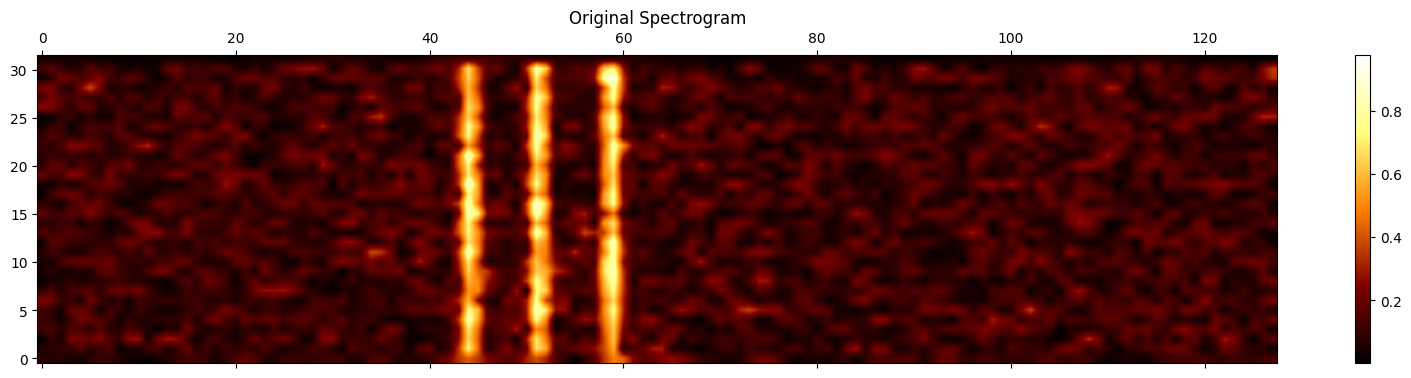

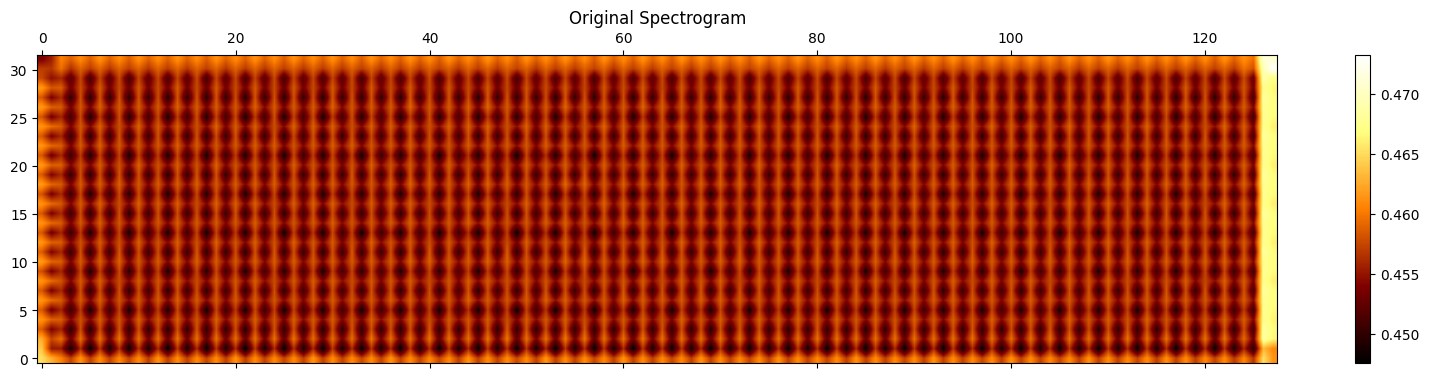

In [221]:
s = test_noisy[3, :]

X = np.abs(signal.stft(s, nperseg=254, noverlap=120)[2]).reshape((1, 128, 32))

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
cax = ax.matshow(np.transpose(X), interpolation='bilinear', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('Original Spectrogram')

res = model.forward(torch.from_numpy(X).to(torch.float32).to(device))

Xres = res.cpu().detach().numpy().reshape(128, 32)

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
cax = ax.matshow(np.transpose(Xres), interpolation='bilinear', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('Original Spectrogram')
